# SMS Classification

+ https://machinelearningmastery.com/naive-bayes-classifier-scratch-python/
+ https://towardsdatascience.com/naive-bayes-classifier-from-scratch-with-python-942708211470
+ https://scikit-learn.org/stable/modules/naive_bayes.html
+ https://pythonspot.com/nltk-stop-words/
+ https://www.youtube.com/watch?v=O2L2Uv9pdDA
+ https://scikit-learn.org/stable/tutorial/text_analytics/working_with_text_data.html

In [1]:
import numpy as np
import pandas as pd

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.linear_model import SGDClassifier

import matplotlib.pyplot as plt
%matplotlib inline

---
## Data Import and Cleaning

__Source:__
https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset

__Cleaning Process:__
1. Tokenize/Split messages
2. Remove unnecessary symbols
3. Stem word
4. 

In [2]:
data = pd.read_csv("./data/spam.csv", encoding="latin1")
data.drop(data.iloc[:, 2:], axis=1, inplace=True)
data["v1"].replace(to_replace="spam", value=1, inplace=True)
data["v1"].replace(to_replace="ham", value=0, inplace=True)

print(data)

      v1                                                 v2
0      0  Go until jurong point, crazy.. Available only ...
1      0                      Ok lar... Joking wif u oni...
2      1  Free entry in 2 a wkly comp to win FA Cup fina...
3      0  U dun say so early hor... U c already then say...
4      0  Nah I don't think he goes to usf, he lives aro...
...   ..                                                ...
5567   1  This is the 2nd time we have tried 2 contact u...
5568   0              Will Ì_ b going to esplanade fr home?
5569   0  Pity, * was in mood for that. So...any other s...
5570   0  The guy did some bitching but I acted like i'd...
5571   0                         Rofl. Its true to its name

[5572 rows x 2 columns]


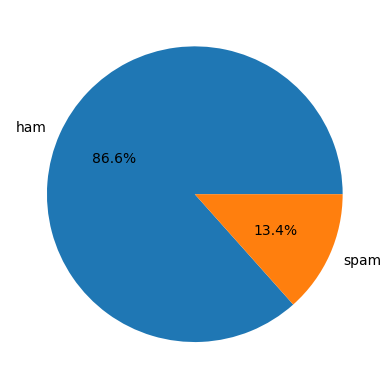

In [3]:
sizes = [data[data["v1"] == 0].shape[0]
        ,data[data["v1"] == 1].shape[0]
        ]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=["ham", "spam"], autopct='%1.1f%%')
plt.show()

In [4]:
# TODO: custom tokenize

def tokenize(m: str) -> list:
    pass


In [5]:
import unicodedata as ud

# https://stackoverflow.com/a/518232
def remove_accents(s: str) -> str:
    return ''.join(c for c in ud.normalize('NFD', s) if ud.category(c) != 'Mn')

In [6]:
# TODO: categorize (numbers, URLs, etc.)

import re

# url_re = re.compile(r'(https?://|www1?\.)?([^/.]+\.[^/.]+)+(/.*)?')
url_re = re.compile(r"(https?://)?(([^/\s]+\.)+[^/\s]+)(/\S*)?")
num_re = re.compile(r'^\d+(\.\d+)?\w{0,3}$')
# phone_re = re.compile(r'\+?[0-9\(\)\-]{5,}')

# NOTE: Stemmed
text_num = {'zero','one','two','three','four','five','six','seven','eight','nine',
            'ten','eleven','twelve','thirteen','fourteen','fifteen','sixteen','seventeen','eighteen','nineteen',
            'twenti','thirti','forti','fifti','sixti','seventi','eighti','nineti',
            'hundrend','thousand','million','billion','trillion'}

def categorize(w: str) -> str:
    if num_re.match(w) or w in text_num:
        return '{{num}}'
    if url_re.match(w):
        return '{{url}}'
    # if phone_re.match(w):
    #     return '{{phone}}'
    if not w.isalpha():
        # TODO: categorize special cases
        return '{{other}}'
    return w

In [7]:
# TODO: normalize

# punc = {',','.','?','!',';',':','(',')','[',']','"',"'",'|','*','^','#','@','%','<','>','{','}','/','\\','`','-','_'}

# 
normals={
    '&': 'and',
    'k': 'okay',
    'ok': 'okay',
    'u': 'you',
    'ur': 'your',
    'xxx': 'sex',
    'plz': 'please',
    'pls': 'please',
    'thk': 'thank',
    'ansr': 'answer',
}

def remove_chars(w: str) -> str:
    if len(w) < 3:
        return w
    nw  = w[0]
    cc  = w[0]
    ccc = 1
    for i in range(1, len(w)):
        if w[i] == cc:
            if ccc == 1:
                nw += cc
            ccc += 1
        else:
            cc = w[i]
            nw += cc
            ccc = 1                        
    return nw

def remove_wrapping_punc(w: str) -> str:
    s, e = 0, len(w)-1
    while s < len(w) and not w[s].isalnum(): s += 1
    while e > s and not w[e].isalnum(): e -= 1
    return w[s:e+1]

def normalize(w: str) -> str:
    # Pre-check
    if normals.get(w) != None:
        return normals.get(w)
    
    k = remove_chars(w)
    k = remove_wrapping_punc(k)
    
    # Post-check
    if normals.get(k) != None:
        return normals.get(k)
    return k

In [8]:
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer

stem = PorterStemmer()

# Tokenize, filter, and stem an SMS message
def processSMS(sms: str) -> list:
    ws = [categorize(normalize(stem.stem(remove_accents(w)))) for w in word_tokenize(sms)]
    return [w for w in ws if len(w) > 0]

data['Vector'] = data["v2"].map(processSMS)
print(data['Vector'])

0       [go, until, jurong, point, {{other}}, crazi, {...
1       [okay, lar, {{other}}, joke, wif, you, oni, {{...
2       [free, entri, in, {{num}}, a, wkli, comp, to, ...
3       [you, dun, say, so, earli, hor, {{other}}, you...
4       [nah, i, do, {{other}}, think, he, goe, to, us...
                              ...                        
5567    [thi, is, the, {{num}}, time, we, have, tri, {...
5568    [will, i, b, go, to, esplanad, fr, home, {{oth...
5569    [piti, {{other}}, {{other}}, wa, in, mood, for...
5570    [the, guy, did, some, bitch, but, i, act, like...
5571            [rofl, {{other}}, it, true, to, it, name]
Name: Vector, Length: 5572, dtype: object


In [9]:
# Gather word statistics
stats = {}
for i in data.index:
    for w in data["Vector"][i]:
        e = [0,0]
        if stats.get(w) != None:
            e = stats.get(w)
        e[data["v1"][i]] += 1
        stats[w] = e

stI = [w for w in stats.items() if sum(w[1]) > 1]

stG = sorted(stI, key=lambda i: i[1][0], reverse=True)
stB = sorted(stI, key=lambda i: i[1][1], reverse=True)

print(len(stI))
print()
print(stG[:20])
print(stB[:20])
print()
print('URLs: ', stats.get('{{url}}'))
print('Numbers: ', stats.get('{{num}}'))
print('Phone Numbers: ', stats.get('{{phone}}'))
print('Other: ', stats.get('{{other}}'))

3177

[('{{other}}', [13071, 3782]), ('i', [2981, 58]), ('you', [2952, 456]), ('and', [1593, 300]), ('to', [1554, 687]), ('{{num}}', [1202, 1847]), ('the', [1121, 206]), ('a', [1054, 377]), ('it', [917, 39]), ('in', [814, 73]), ('me', [776, 30]), ('my', [748, 11]), ('is', [741, 158]), ('your', [666, 422]), ('do', [598, 35]), ('that', [588, 26]), ('of', [524, 95]), ('have', [502, 136]), ('for', [501, 203]), ('s', [453, 86])]
[('{{other}}', [13071, 3782]), ('{{num}}', [1202, 1847]), ('to', [1554, 687]), ('you', [2952, 456]), ('your', [666, 422]), ('a', [1054, 377]), ('call', [292, 366]), ('and', [1593, 300]), ('{{url}}', [380, 249]), ('free', [59, 219]), ('the', [1121, 206]), ('for', [501, 203]), ('now', [295, 199]), ('or', [230, 188]), ('txt', [13, 169]), ('is', [741, 158]), ('on', [392, 144]), ('text', [86, 139]), ('have', [502, 136]), ('mobil', [15, 135])]

URLs:  [380, 249]
Numbers:  [1202, 1847]
Phone Numbers:  None
Other:  [13071, 3782]


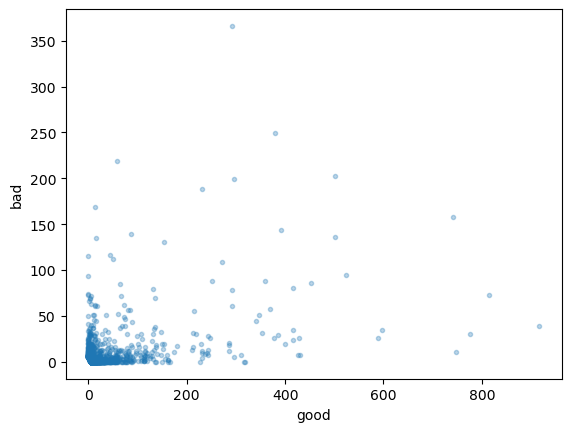

In [10]:
s = [v for v in stats.values() if sum(v) in range(5, 1000)]
x = [v[0] for v in s]
y = [v[1] for v in s]


fig2, ax2 = plt.subplots()
ax2.scatter(x, y, marker='.', alpha=0.3)
ax2.set_xlabel('good')
ax2.set_ylabel('bad')
plt.show()

---
## Training and Testing

+ Data splitting
+ Testing Multinomial Naive Bayes
+ Testing Support Vector Machine

In [11]:
def joinItems(ws: list) -> str:
    return ' '.join(ws)
    
vs = data['Vector'].map(joinItems).values

trainX, testX, trainY, testY = train_test_split(vs, data['v1'], test_size=0.3, random_state=42)

In [12]:
mnb = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'(?u)\b\w\w+\b|\{\{\w+\}\}')),
    ('clf', MultinomialNB()),
])
mnb.fit(trainX, trainY)

pred = mnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.98      0.99      0.99      1453
         bad       0.94      0.89      0.92       219

    accuracy                           0.98      1672
   macro avg       0.96      0.94      0.95      1672
weighted avg       0.98      0.98      0.98      1672



In [13]:
svm = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'(?u)\b\w\w+\b|\{\{\w+\}\}')),
    ('clf', SGDClassifier(loss='hinge', penalty='l2', alpha=1e-3, random_state=42, max_iter=5, tol=None)),
])
svm.fit(trainX, trainY)

pred = svm.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.99      1.00      0.99      1453
         bad       0.98      0.90      0.94       219

    accuracy                           0.99      1672
   macro avg       0.99      0.95      0.97      1672
weighted avg       0.99      0.99      0.98      1672



In [14]:
cnb = Pipeline([
    ('vect', CountVectorizer(token_pattern=r'(?u)\b\w\w+\b|\{\{\w+\}\}')),
    ('clf', ComplementNB()),
])
cnb.fit(trainX, trainY)

pred = cnb.predict(testX)
print(metrics.classification_report(testY, pred, target_names=['good','bad']))

              precision    recall  f1-score   support

        good       0.99      0.98      0.98      1453
         bad       0.85      0.92      0.89       219

    accuracy                           0.97      1672
   macro avg       0.92      0.95      0.93      1672
weighted avg       0.97      0.97      0.97      1672



---
## Post-Processing

+ Code generation
+ Other statistics

In [17]:
names  = mnb.steps[0][1].get_feature_names_out()
values = mnb.steps[-1][1].feature_log_prob_
size   = len(values[0])

rng = ""
cnt = ""

cc   = names[0][0]
low  = 0
high = 0

# Generate Code for the Flutter App
for i, n in enumerate(names):
    if cc != n[0]:
        rng += "'{0}': Region({1}, {2}),\n".format(cc, low, high)
        low = high+1
        cc = n[0]    
    cnt += "DictEntry('{0}', {1}, {2}),\n".format(n, values[0][i], values[1][i])
    high = i

# Add last region
rng += "'{0}': Region({1}, {2}),\n".format(cc, low, high)

with open("../lib/utils/spam_vocabulary.dart", "w") as f:
    f.write("part of 'spam_filter.dart';\n\n")
    f.write('//=================================================//\n\n')
    f.write('/// Contains the log likelihoods used to make a multinomial naive bayes prediction.\n')
    f.write('///\n')
    f.write('/// (Code generated by python script `model/sms.ipynb`)\n')
    f.write("const vocabulary = Dictionary(\n")
    f.write('{')
    f.write(rng)
    f.write('},\n')
    f.write('[')
    f.write(cnt)
    f.write('],\n')
    f.write(');')

In [16]:
dropped = []

for i in stats.items():
    if i[0] not in names:
        dropped.append(i)
        
print(len(dropped))
print(sorted(dropped))

984
[('a', [1054, 377]), ('aaniy', [1, 0]), ('abdomen', [1, 0]), ('absenc', [1, 0]), ('absolut', [1, 0]), ('aburo', [2, 0]), ('abus', [1, 1]), ('accentur', [1, 0]), ('achiev', [1, 0]), ('acnt', [1, 0]), ('actin', [1, 0]), ('adjust', [1, 0]), ('adsens', [1, 0]), ('advanc', [7, 0]), ('advisor', [0, 1]), ('affection', [1, 0]), ('afternon', [1, 0]), ('agalla', [2, 0]), ('ahh', [2, 0]), ('alertfrom', [0, 1]), ('alett', [1, 0]), ('alian', [1, 0]), ('alibi', [1, 0]), ('allalo', [1, 0]), ('allo', [1, 0]), ('amanda', [0, 1]), ('amma', [1, 0]), ('amongst', [2, 0]), ('amus', [2, 0]), ('anal', [1, 0]), ('analysi', [1, 0]), ('anand', [1, 0]), ('anji', [1, 0]), ('anniversari', [2, 0]), ('anonym', [0, 1]), ('antibiot', [1, 0]), ('anyhow', [1, 0]), ('anythi', [1, 0]), ('anythingtomorrow', [1, 0]), ('aoharri', [0, 1]), ('aoit', [0, 1]), ('aom', [0, 2]), ('aomorrow', [1, 0]), ('ape', [1, 0]), ('apeshit', [1, 0]), ('apologet', [1, 0]), ('appendix', [1, 0]), ('appl', [1, 0]), ('applic', [2, 0]), ('appropr